![Logo_Conestoga](https://upload.wikimedia.org/wikipedia/commons/3/34/Conestoga_College_logo.png)

Foundations of Machine Learning Frameworks
&nbsp; 

CSCN8010 - Winter 2024
&nbsp; 

Professor: Ran Feldesh
&nbsp;

Student: Arcadio de Paula Fernandez


# Lab 10 - Vanilla CNN and Fine-Tune VGG16 - for Dogs and Cats Classification



# 1. Introduction: A brief introduction to the problem, libraries and obtaining the data.

###  1.1. A brief introduction to the problem

In this lab, we will work through a common practice of Deep Learning Engineers - that is - take an existing model, that does something similar to what the engineer is interested doing, and fine-tune it for the specific task at-hand. For this we will write an algorithm to classify whether images contain either a dog or a cat.  This is easy for humans, dogs, and cats. Your computer will find it a bit more difficult. 

[Dataset](https://www.kaggle.com/c/dogs-vs-cats) Description
The training archive contains 25,000 images of dogs and cats. Train your algorithm on these files and predict the labels for test1.zip (1 = dog, 0 = cat).

### 1.2. Importing all the essential libraries and sub modules

In [1]:
from tensorflow import keras
from tensorflow.keras import layers
import pathlib
from tensorflow.keras.utils import image_dataset_from_directory
import matplotlib.pyplot as plt

### 1.3. Obtaining the Data

In [2]:
import os, shutil, pathlib

original_dir = pathlib.Path(r"C:\Users\arcad\CSCN8010-labs\Lab10-Arca\train")
new_base_dir = pathlib.Path(r"C:\Users\arcad\CSCN8010-labs\Lab10-Arca\subsets")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir, exist_ok=True)  # Modified line
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)


The code above create a small dataset of 1000 training images, 500 validation images and 1000 test images *per class*. This reduces the dataset from 25,000 images to 5000.

# 2. Exploratory data analysis - EDA

### 2.1. Determine the size of each subset (train, validation, test)

In [3]:
import os

def count_images_in_subset(base_dir, subset_name):
    """
    Count the number of .jpg images in a given subset of the dataset.
    """
    subset_path = os.path.join(base_dir, subset_name)
    total_images = 0
    for root, dirs, files in os.walk(subset_path):
        for file in files:
            if file.endswith('.jpg'):
                total_images += 1
    return total_images

# Base directory where the subsets are stored
base_dir = r"C:\Users\arcad\CSCN8010-labs\Lab10-Arca\subsets"

# Count and print the number of images in each subset
for subset_name in ["train", "validation", "test"]:
    image_count = count_images_in_subset(base_dir, subset_name)
    print(f"The {subset_name} subset contains {image_count} images.")


The train subset contains 2000 images.
The validation subset contains 1000 images.
The test subset contains 2000 images.


### 2.2.  Randmoly scroll through the images from the 3 subsets:

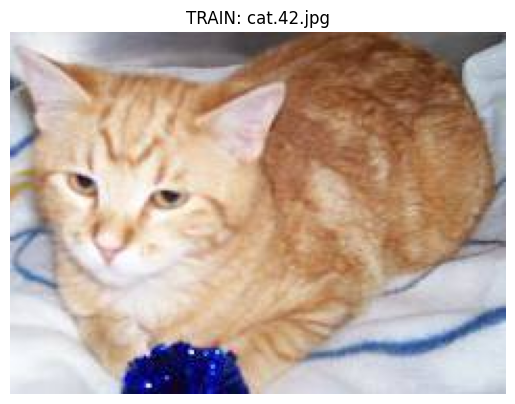

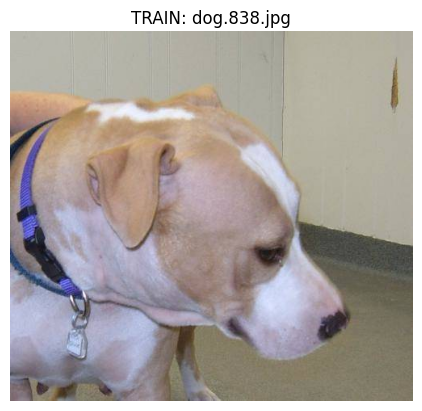

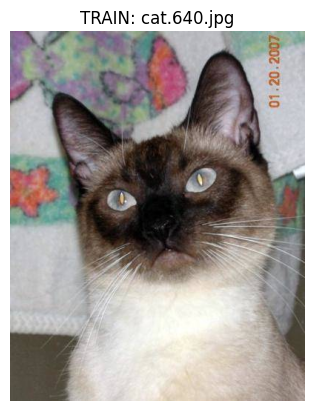

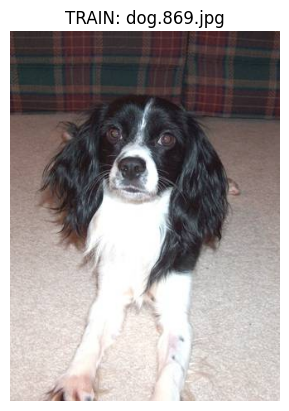

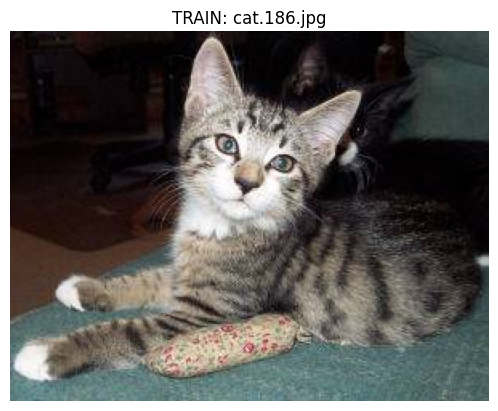

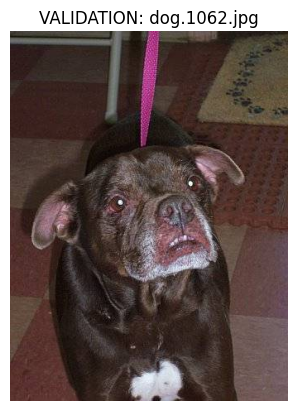

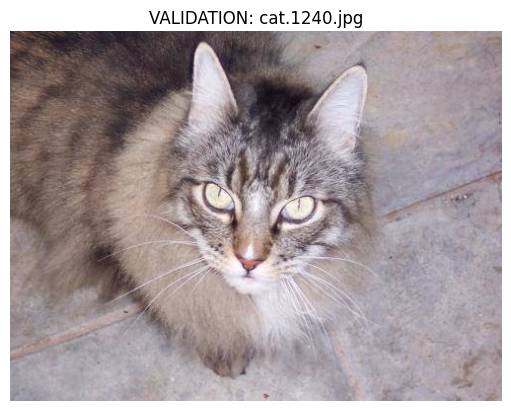

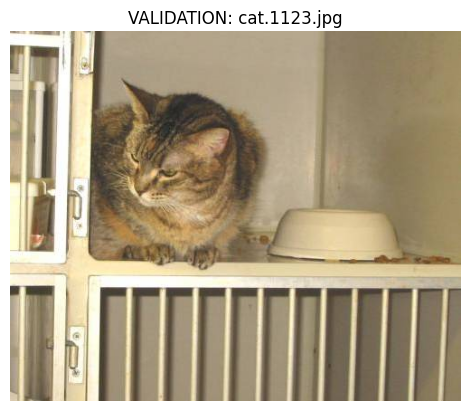

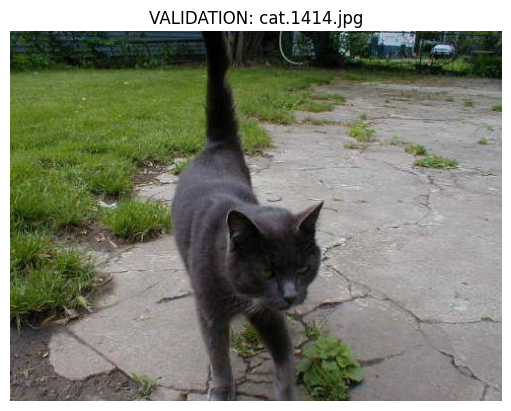

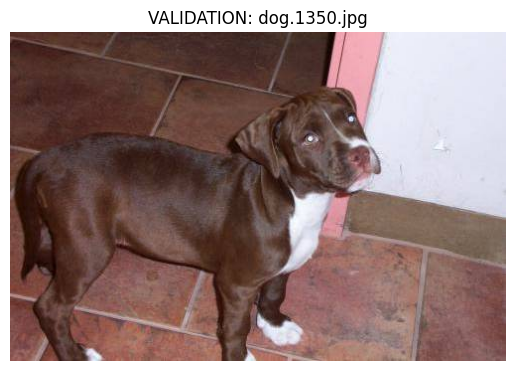

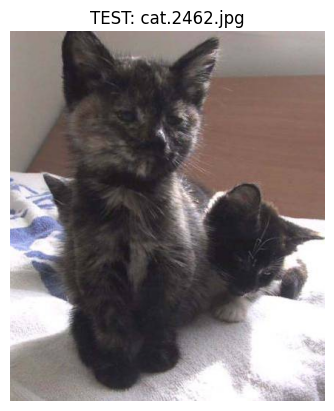

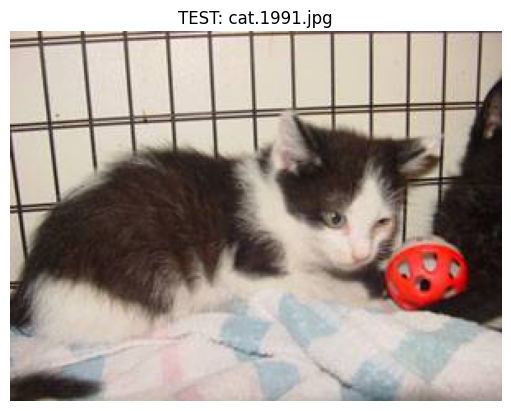

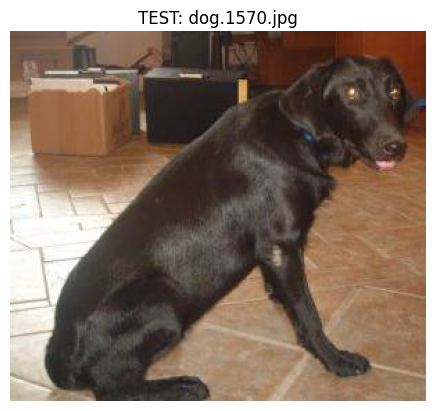

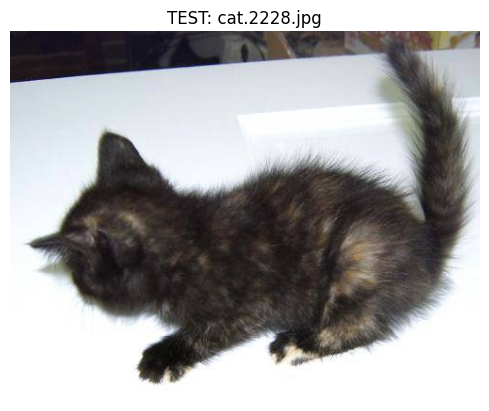

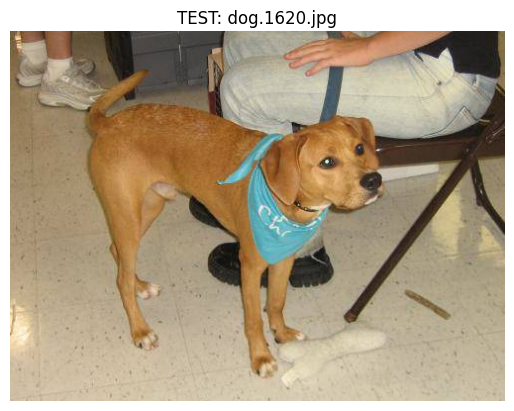

In [4]:
import matplotlib.pyplot as plt
from PIL import Image
import random
from pathlib import Path  # Use pathlib for path handling

def display_random_images(base_path, subset_name, num_images=5):
    """
    Display random images from the specified subset and base path.
    """
    all_files = []
    # Construct the full path for the subset
    subset_path = Path(base_path) / subset_name
    
    # Loop through each class directory in the subset and collect image paths
    for class_dir in subset_path.iterdir():
        if class_dir.is_dir():  # Ensure it's a directory
            for file in class_dir.glob('*.jpg'):
                all_files.append(file)
    
    # Ensure not to exceed the total number of images available
    selected_files = random.sample(all_files, min(len(all_files), num_images))
    
    for file in selected_files:
        img = Image.open(file)
        plt.figure()
        plt.imshow(img)
        plt.title(f"{subset_name.upper()}: {file.name}")
        plt.axis('off')
    plt.show()

# Base path where the subsets are located
base_path = r"C:\Users\arcad\CSCN8010-labs\Lab10-Arca\subsets"

# Display random images from each subset
display_random_images(base_path, "train", 5)
display_random_images(base_path, "validation", 5)
display_random_images(base_path, "test", 5)


### 2.3. Insights from the Perspective of Training and Testing

While scrolling through the images, we can notice:

Variability: There are variations in the background, poses, or sizes of the animals, and these can affect the model's ability to generalize.
Quality: There are some quality issues such as blurriness, which might affect model performance.

### 2.4. Determine the Size in Pixels


To find out the size of the images of each subset, we are going to use the PIL.Image module:


Analyzing train subset:


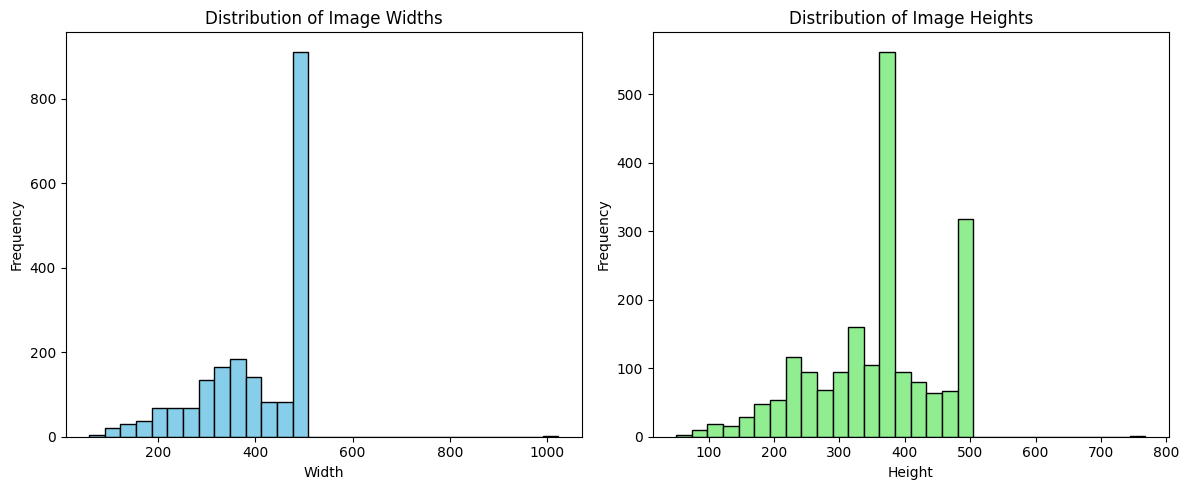

Basic Statistics:
              width       height
count  2000.000000  2000.000000
mean    403.972500   358.917500
std     109.258846    97.419413
min      59.000000    50.000000
25%     320.000000   300.000000
50%     442.500000   374.000000
75%     499.000000   418.000000
max    1023.000000   768.000000

Most Common Image Size:
       width  height  count
1098    500     374    226

Analyzing validation subset:


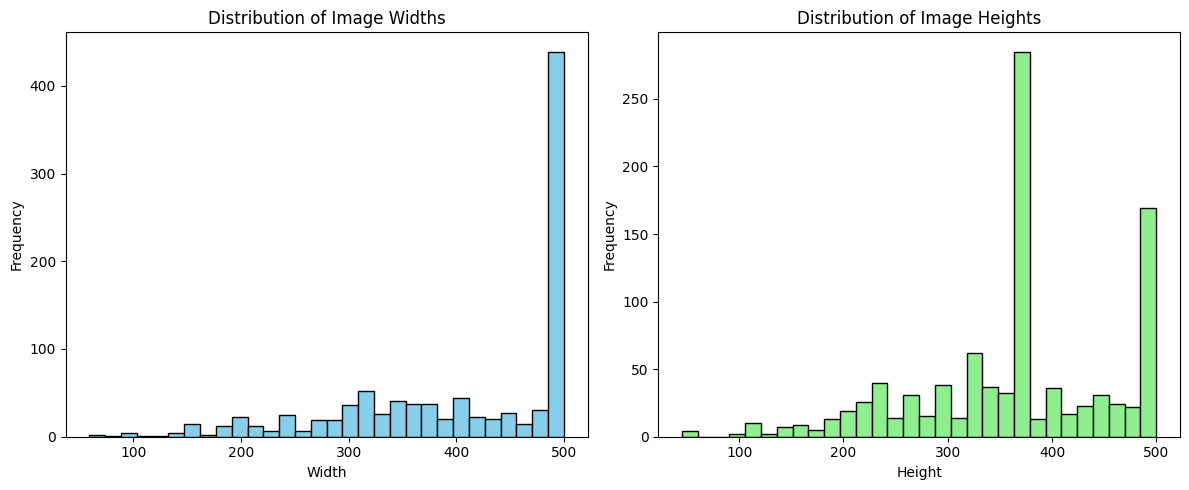

Basic Statistics:
              width       height
count  1000.000000  1000.000000
mean    407.214000   365.296000
std     105.870566    95.833744
min      59.000000    45.000000
25%     331.500000   318.750000
50%     448.000000   374.000000
75%     499.000000   435.250000
max     500.000000   500.000000

Most Common Image Size:
      width  height  count
505    499     375    126

Analyzing test subset:


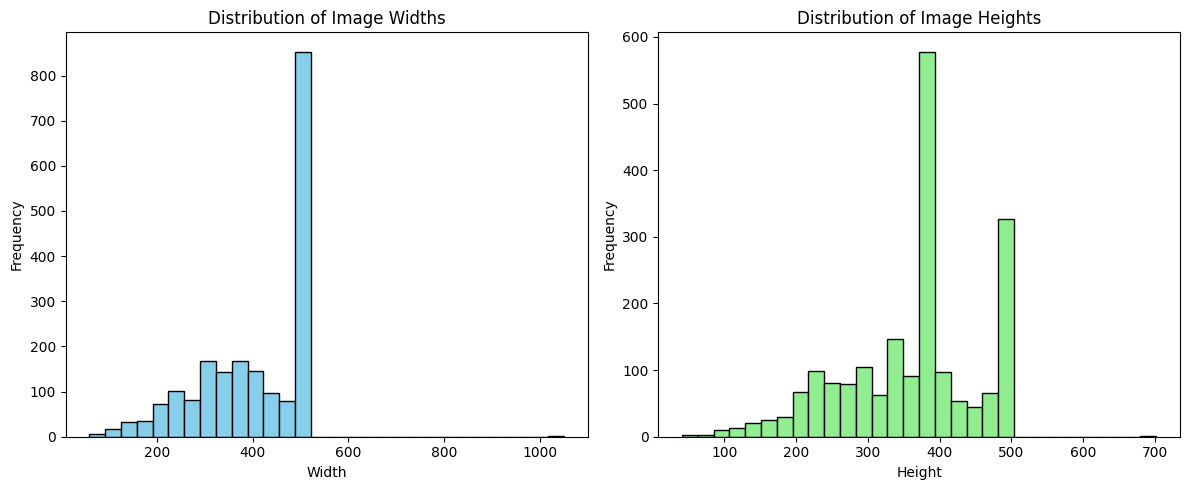

Basic Statistics:
              width       height
count  2000.000000  2000.000000
mean    402.127000   359.846000
std     109.445996    96.158773
min      59.000000    41.000000
25%     320.000000   299.000000
50%     433.000000   374.000000
75%     499.000000   415.000000
max    1050.000000   702.000000

Most Common Image Size:
      width  height  count
951    499     375    230


In [5]:
from PIL import Image
import os
import pandas as pd
import matplotlib.pyplot as plt
import pathlib

def summarize_image_dataset(path):
    data = []  # List to hold image statistics

    # Convert to string if the path is a pathlib.Path object (for os.walk compatibility)
    path = str(path)  
    for root, dirs, files in os.walk(path):
        for file in files:
            if file.endswith('.jpg'):
                img_path = os.path.join(root, file)
                img = Image.open(img_path)
                # Append image filename, width, and height to the data list
                data.append({'filename': file, 'width': img.width, 'height': img.height})

    # Create DataFrame from collected data
    df = pd.DataFrame(data)
    return df

def visualize_and_analyze(df):
    # Basic statistics
    basic_stats = df.describe()

    # Most common image size
    most_common_size = df.groupby(['width', 'height']).size().reset_index(name='count').sort_values(by='count', ascending=False).head(1)

    # Plot distribution of widths and heights
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.hist(df['width'], bins=30, color='skyblue', edgecolor='black')
    plt.title('Distribution of Image Widths')
    plt.xlabel('Width')
    plt.ylabel('Frequency')

    plt.subplot(1, 2, 2)
    plt.hist(df['height'], bins=30, color='lightgreen', edgecolor='black')
    plt.title('Distribution of Image Heights')
    plt.xlabel('Height')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

    # Output the basic statistics and most common size
    print("Basic Statistics:\n", basic_stats)
    print("\nMost Common Image Size:\n", most_common_size)

# Base directory path
base_dir = pathlib.Path(r"C:\Users\arcad\CSCN8010-labs\Lab10-Arca\subsets")

# Analyze each subset within the base directory
for subset in ["train", "validation", "test"]:
    print(f"\nAnalyzing {subset} subset:")
    path = base_dir / subset
    df = summarize_image_dataset(path)
    visualize_and_analyze(df)


Analyzing train subset:

Mean Width & Height: The average dimensions of the images are approximately 404 pixels in width and 359 pixels in height, suggesting a wide variety of sizes but with a tendency towards a standard medium size.

Min & Max: The smallest image is 59x50 pixels, and the largest is 1023x768 pixels, highlighting a broad range in the sizes of the images contained within the dataset.

In the histograms we can visualize the distribution with tehe broad range of image widths and heights in your dataset.

The same happens in the test and validation subsets with a wide variety of sizes:  

Validation subset:<br> 
Mean Width & Height: 407 pixels in width and 365 pixels in height
Min & Max: smallest image is 59x45 pixels, and the largest is 500x500 pixels

Test subset:<br>  
Mean Width & Height: 402 pixels in width and 359 pixels in height
Min & Max: smallest image is 59x41 pixels, and the largest is 1050x702 pixels

Data Preparation: Knowing the distribution of image sizes can be crucial for preparing your data for machine learning models. You might need to resize or pad images to ensure they're a uniform size for input into your model.

### 2.4. Identify the Color Scheme

In [6]:
from PIL import Image
import os
import pathlib

def check_color_schemes(base_dir):
    """
    Check the color schemes (color modes) used in the images across all specified subsets
    within the base directory.
    """
    # Define the subsets 
    subsets = ["train", "validation", "test"]
    base_dir = pathlib.Path(base_dir)  
    
    for subset in subsets:
        color_modes = set()  # Initialize a set to store unique color modes found
        subset_path = base_dir / subset  # Construct the path to the current subset
        
        for root, dirs, files in os.walk(subset_path):
            for file in files:
                if file.endswith('.jpg'):
                    img_path = os.path.join(root, file)
                    with Image.open(img_path) as img:
                        color_modes.add(img.mode)
        
        # Print the unique color modes found in the current subset
        print(f"Color modes found in {subset} subset:", color_modes)

# Base directory where the subsets are stored
base_dir = r"C:\Users\arcad\CSCN8010-labs\Lab10-Arca\subsets"

# Call the function with the path to the base directory
check_color_schemes(base_dir)


Color modes found in train subset: {'RGB'}
Color modes found in validation subset: {'RGB'}
Color modes found in test subset: {'RGB'}


This above script give us an overview of the color schemes present in your subset, where:

"RGB" indicates a full-color image.
"L" indicates a grayscale image.

As the result is: "RGB" indicates a full-color image in our subsets.

# **Train two networks (make sure to use callbacks to save the best model version as done in lab 9):**

# 3. Modeling - Neural Network of my choice

In [9]:
# This should point to the small dataset of the Kaggle Dogs vs Cats competition that was created previously 
data_folder = pathlib.Path(r"C:\Users\arcad\CSCN8010-labs\Lab10-Arca\subsets")

In [10]:
train_dataset = image_dataset_from_directory(
    data_folder / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    data_folder / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    data_folder / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


### 3.1. Defining a Neural Network of my choice

In [8]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                         

### 3.2. Before training a model, you need to configure the learning process, which is done via the compile method. --> `model.compile(...)`

This line of code is used in the context of training a neural network using Keras, the code configures the model for binary classification by specifying the loss function, optimizer, and evaluation metrics to use. After this configuration, the model will be ready to start the training process with a call to model.fit(...)

In [11]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

### 3.3.  Train the model on a training dataset for a specified number of epochs (in this case 30 epochs) while evaluating it on a validation dataset and initializes a callback for saving the best version of a model based on validation loss. 

In [13]:
import os

# Creating a directory for model checkpoints 
model_dir = "./models"
os.makedirs(model_dir, exist_ok=True)

#"C:\Users\arcad\OneDrive\Área de Trabalho\02_Machine Learning Engineer\09_Conestoga_Applied AI_ML\
# 01_Conestoga_Term 1\02_Foundations ML_Ran\00_ML_Lab_Sandbox\Lab10-Arca\models\convnet_from_scratch.keras"


In [14]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="./models/convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 32s 515ms/step - loss: 0.6864 - accuracy: 0.5550 - val_loss: 0.6735 - val_accuracy: 0.5760
Epoch 2/30
63/63 [==============================] - 32s 511ms/step - loss: 0.6519 - accuracy: 0.6255 - val_loss: 0.6771 - val_accuracy: 0.5620
Epoch 3/30
63/63 [==============================] - 32s 510ms/step - loss: 0.6245 - accuracy: 0.6615 - val_loss: 0.6817 - val_accuracy: 0.5660
Epoch 4/30
63/63 [==============================] - 33s 516ms/step - loss: 0.6002 - accuracy: 0.6765 - val_loss: 0.5800 - val_accuracy: 0.6950
Epoch 5/30
63/63 [==============================] - 32s 515ms/step - loss: 0.5417 - accuracy: 0.7220 - val_loss: 0.6221 - val_accuracy: 0.6630
Epoch 6/30
63/63 [==============================] - 33s 517ms/step - loss: 0.5311 - accuracy: 0.7465 - val_loss: 0.6163 - val_accuracy: 0.6940
Epoch 7/30
63/63 [==============================] - 32s 514ms/step - loss: 0.4732 - accuracy: 0.7760 - val_loss: 0.5693 - val_accuracy: 0.7260

### 3.4. Displaying curves of loss and accuracy during training

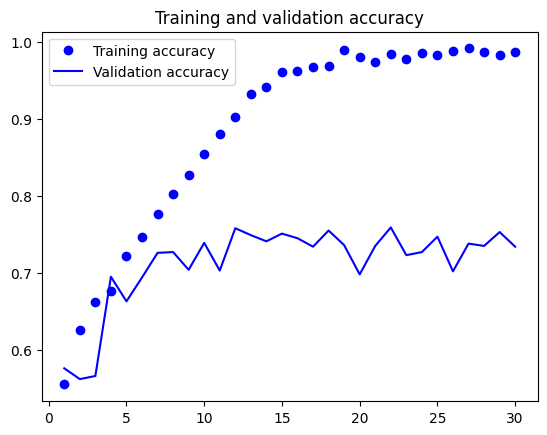

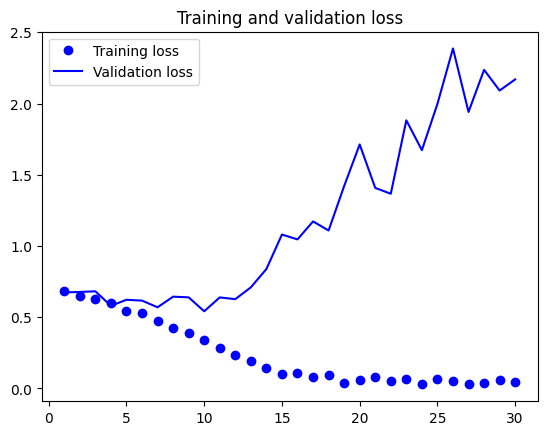

In [15]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

Overfitting is evident, around epoch 10. 

### 3.5. Running Model (Reduced Size) with 10 epochs

The model does sign of overfitting slightly in epoch 10 both loss and accuracy curves stabilize, (so the best set of weights would likely be around epoch 10) in other words, the best epoch to stop training and select the set of weights, so we are running with 10 epochs instead of 30 form the code above.

In [24]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="./models/convnet_from_scratch2.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/10
63/63 [==============================] - 34s 535ms/step - loss: 0.0273 - accuracy: 0.9905 - val_loss: 2.5650 - val_accuracy: 0.7230
Epoch 2/10
63/63 [==============================] - 33s 522ms/step - loss: 0.0386 - accuracy: 0.9900 - val_loss: 2.0674 - val_accuracy: 0.7350
Epoch 3/10
63/63 [==============================] - 33s 525ms/step - loss: 0.0269 - accuracy: 0.9925 - val_loss: 2.1206 - val_accuracy: 0.7510
Epoch 4/10
63/63 [==============================] - 33s 522ms/step - loss: 9.2333e-04 - accuracy: 1.0000 - val_loss: 2.1934 - val_accuracy: 0.7650
Epoch 5/10
63/63 [==============================] - 33s 522ms/step - loss: 0.0566 - accuracy: 0.9885 - val_loss: 2.3024 - val_accuracy: 0.7500
Epoch 6/10
63/63 [==============================] - 33s 520ms/step - loss: 0.0236 - accuracy: 0.9930 - val_loss: 3.2026 - val_accuracy: 0.7260
Epoch 7/10
63/63 [==============================] - 33s 526ms/step - loss: 0.0581 - accuracy: 0.9845 - val_loss: 2.9322 - val_accuracy: 0.

# 4. Evaluation - Neural Network of my choice

### 4.1. Accuracy
Accuracy can be directly obtained from the model's evaluation on the test dataset

In [21]:
test_model = keras.models.load_model(r"C:\Users\arcad\CSCN8010-labs\Lab10-Arca\models\convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 8s 128ms/step - loss: 0.5665 - accuracy: 0.7185
Test accuracy: 0.719


This dataset is not used during the training phase and serves to evaluate the model's performance in an unbiased way. An accuracy of 71.9% suggests that the model is fairly good at making correct predictions.

### 4.2. Calculate Other Metrics

- Confusion Matrix

- Precision, Recall, and F1-score

- Precision-Recall Curve

63/63 [==============================] - 8s 126ms/step
Confusion Matrix:
 [[458 542]
 [487 513]]
              precision    recall  f1-score   support

     Class 0       0.48      0.46      0.47      1000
     Class 1       0.49      0.51      0.50      1000

    accuracy                           0.49      2000
   macro avg       0.49      0.49      0.49      2000
weighted avg       0.49      0.49      0.49      2000



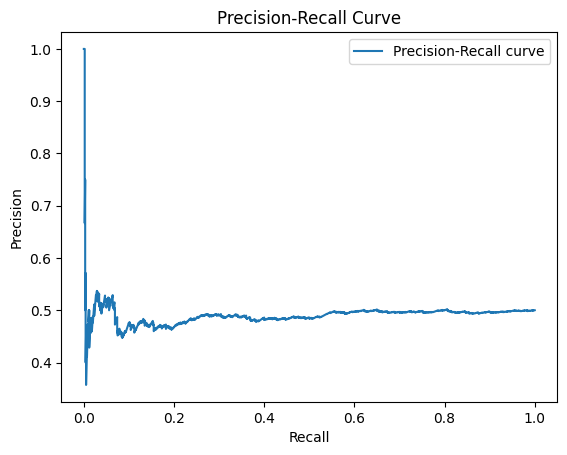

In [23]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

# Get true labels from the test dataset
y_true = np.concatenate([y for x, y in test_dataset], axis=0)

# Make predictions with the model
predictions = test_model.predict(test_dataset)

# For binary classification, determine the class based on the prediction probability threshold (e.g., 0.5)
y_pred = (predictions > 0.5).astype("int32").flatten()

# Calculate and print the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# Calculate precision, recall, F1-score
print(classification_report(y_true, y_pred, target_names=['Class 0', 'Class 1']))

# Precision-Recall Curve
# Note: `predictions` here are the raw probabilities from the model's output
precision, recall, thresholds = precision_recall_curve(y_true, predictions)

# Plot the Precision-Recall curve
plt.figure()
plt.plot(recall, precision, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()


The feedback on your model's performance suggests it's achieving results slightly better than a random guess in a binary classification problem, with an overall accuracy of 49%. This is very close to a 50/50 random guess if we think of accuracy 

Confusion Matrix: This distribution suggests your model equally recognizes correct and incorrect classifications. However, the high number of false positives and false negatives indicates that the model is having problems classifying the classes into correct categories. 

The F1-score, around 0.47 to 0.50 for both classes. Confirms the model's moderate performance in balancing precision and recall.

Precision-recall curve:  A very sharp drop in precision right at the beginning, indicating that the model is only highly confident about a very small set of its positive predictions. For most of the recall range, the precision remains roughly constant but at a lower value, which means the model does not distinguish between classes as effectively as it could.

### 4.3. Accuracy - Model (Reduced Size) with 10 epochs

In [26]:
test_model2 = keras.models.load_model(r"C:\Users\arcad\CSCN8010-labs\Lab10-Arca\models\convnet_from_scratch2.keras")
test_loss, test_acc = test_model2.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 8s 119ms/step - loss: 2.3261 - accuracy: 0.7220
Test accuracy: 0.722


### 4.4. Calculate Other - Model (Reduced Size) with 10 epochs

- Confusion Matrix

- Precision, Recall, and F1-score

- Precision-Recall Curve

63/63 [==============================] - 8s 124ms/step
Confusion Matrix:
 [[369 631]
 [413 587]]
              precision    recall  f1-score   support

     Class 0       0.47      0.37      0.41      1000
     Class 1       0.48      0.59      0.53      1000

    accuracy                           0.48      2000
   macro avg       0.48      0.48      0.47      2000
weighted avg       0.48      0.48      0.47      2000



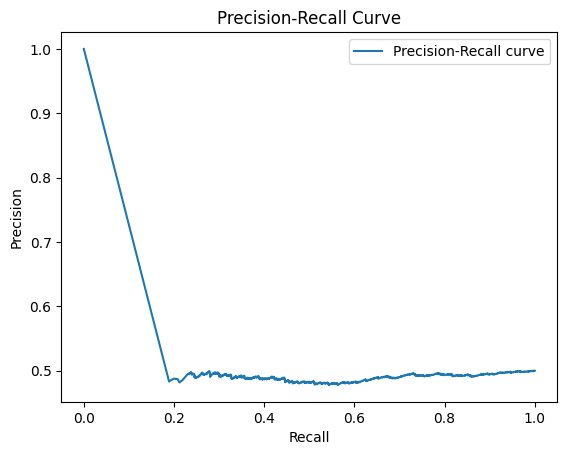

In [27]:
# Get true labels from the test dataset
y_true = np.concatenate([y for x, y in test_dataset], axis=0)

# Make predictions with the model
predictions = test_model2.predict(test_dataset)

# For binary classification, determine the class based on the prediction probability threshold (e.g., 0.5)
y_pred = (predictions > 0.5).astype("int32").flatten()

# Calculate and print the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# Calculate precision, recall, F1-score
print(classification_report(y_true, y_pred, target_names=['Class 0', 'Class 1']))

# Precision-Recall Curve
# Note: `predictions` here are the raw probabilities from the model's output
precision, recall, thresholds = precision_recall_curve(y_true, predictions)

# Plot the Precision-Recall curve
plt.figure()
plt.plot(recall, precision, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()


The confusion matrix: shows that out of 1000 samples for each class, the model correctly predicted 369 instances of class 0 and 587 instances of class 1. This suggests the model is better at identifying class 1 instances.

Overall, this model reduce model (10 epochs) seems to perform slightly better on class 1 than on class 0, but generally, it is not performing particularly well for either class as model (30 epochs).

### 4.5. Conclusion Evaluation 

Given these 2 results of the model with 30 epochs and the modelm with 10 epochs, we might consider using Data Augmentation. Augmenting our data can help the model generalize better. Techniques like flipping images horizontally, rotating, zooming, and shifting can make our model more robust.

Or consider using fine-tuning and hyperparameter tuning methods of optimizing a model, that can also can make our model more robust.

### 4.6. Exploring specific examples in which the model failed to predict correctly.

# 5. Modeling Fine-Tune VGG16 (pre-trained on imagenet). 

Make sure to use validation to test for over-fitting. Plot the appropriate graph 

In [28]:
# This should point to the small dataset of the Kaggle Dogs vs Cats competition that was created previously 
data_folder = pathlib.Path(r"C:\Users\arcad\CSCN8010-labs\Lab10-Arca\subsets")

In [32]:
train_dataset2 = image_dataset_from_directory(
    data_folder / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset2 = image_dataset_from_directory(
    data_folder / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset2 = image_dataset_from_directory(
    data_folder / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


### 5.1. Defining the Fine-Tune VGG16 (pre-trained on imagenet) 

In [30]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

58889256/58889256 [==============================] - 1s 0us/step


In [31]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

In [33]:
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset2)
val_features, val_labels =  get_features_and_labels(validation_dataset2)
test_features, test_labels =  get_features_and_labels(test_dataset2)

1/1 [==============================] - 1s 727ms/step


In [34]:
train_features.shape

(2000, 5, 5, 512)

These are 1000 images for each of the two classes, and then a 5x5 spatial matrix with a depth of 512 filters. 

### 5.2. Defining and training the densely connected classifier

Here we define a new dense neural networks, of only two (neuronal/trainable) layers.

In [35]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

In [36]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 5, 5, 512)]       0         
                                                                 
 flatten_1 (Flatten)         (None, 12800)             0         
                                                                 
 dense_1 (Dense)             (None, 256)               3277056   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 257       
                                                                 
Total params: 3,277,313
Trainable params: 3,277,313
Non-trainable params: 0
_________________________________________________________________


In [38]:
import os

# Creating a directory for model checkpoints 
model_dir = "./models"
os.makedirs(model_dir, exist_ok=True)


### 5.3.  Train the model on a training dataset for a specified number of epochs (in this case 20 epochs) while evaluating it on a validation dataset and initializes a callback for saving the best version of a model based on validation loss. 

In [40]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="./models/feature_extraction3.keras",
      save_best_only=True,
      monitor="val_loss")
]
history = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/20


63/63 [==============================] - 2s 22ms/step - loss: 2.3980 - accuracy: 0.9810 - val_loss: 6.1593 - val_accuracy: 0.9700
Epoch 2/20
63/63 [==============================] - 1s 22ms/step - loss: 1.1897 - accuracy: 0.9910 - val_loss: 4.5456 - val_accuracy: 0.9780
Epoch 3/20
63/63 [==============================] - 1s 20ms/step - loss: 0.9569 - accuracy: 0.9905 - val_loss: 6.8579 - val_accuracy: 0.9730
Epoch 4/20
63/63 [==============================] - 1s 20ms/step - loss: 0.6616 - accuracy: 0.9945 - val_loss: 4.5690 - val_accuracy: 0.9780
Epoch 5/20
63/63 [==============================] - 1s 21ms/step - loss: 0.6069 - accuracy: 0.9960 - val_loss: 4.4722 - val_accuracy: 0.9790
Epoch 6/20
63/63 [==============================] - 1s 22ms/step - loss: 0.1224 - accuracy: 0.9970 - val_loss: 5.4741 - val_accuracy: 0.9770
Epoch 7/20
63/63 [==============================] - 1s 21ms/step - loss: 0.2024 - accuracy: 0.9965 - val_loss: 5.4701 - val_accuracy: 0.9770
Epoch 8/20
63/63 [======

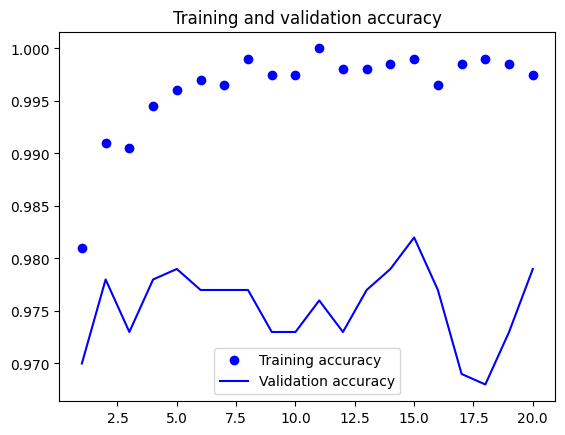

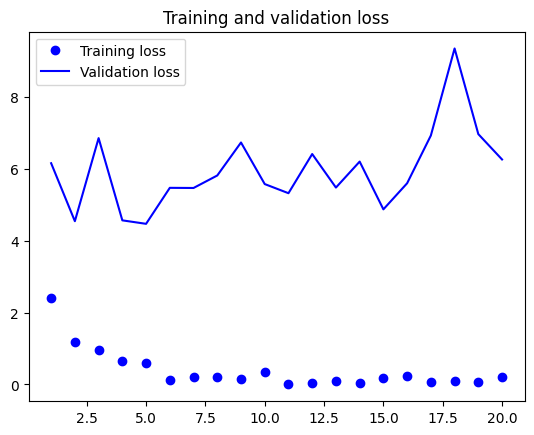

In [41]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In the training and validation accuracy graph training  accuracythe is consistently high and slightly improving as the epochs increase, nearly reaching 100%. On the other hand, the validation accuracy  fluctuates as training progresses. This kind of discrepancy might suggest overfitting, as the model performs better on the training data than it does on the unseen validation data.

# 6. Evaluation the Fine-Tune VGG16 (pre-trained on imagenet)

### 6.1. Accuracy
Accuracy can be directly obtained from the model's evaluation on the test dataset

In [45]:
test_model = keras.models.load_model(
    r"C:\Users\arcad\CSCN8010-labs\Lab10-Arca\models\feature_extraction3.keras")
test_loss, test_acc = test_model.evaluate(x=test_features, y=test_labels)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 0s 2ms/step - loss: 5.8205 - accuracy: 0.9730
Test accuracy: 0.973


An accuracy of 97.3% suggests that the model is excellent at making correct predictions

### 6.2. Calculate Other Metrics

- Confusion Matrix

- Precision, Recall, and F1-score

In [50]:
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# Generate predictions
pred_probabilities = test_model.predict(test_features)
pred_labels = (pred_probabilities > 0.5).astype("int32")

# Confusion Matrix
conf_matrix = confusion_matrix(test_labels, pred_labels)
print("Confusion Matrix:\n", conf_matrix)

# Precision, Recall, and F1-Score
precision = precision_score(test_labels, pred_labels)
recall = recall_score(test_labels, pred_labels)
f1 = f1_score(test_labels, pred_labels)
print(f"Precision: {precision:.3f}, Recall: {recall:.3f}, F1-Score: {f1:.3f}")



18/63 [=======>......................] - ETA: 0s

63/63 [==============================] - 0s 3ms/step
Confusion Matrix:
 [[981  19]
 [ 35 965]]
Precision: 0.981, Recall: 0.965, F1-Score: 0.973


Confusion Matrix: Your confusion matrix shows the number of true positives (TP = 981), true negatives (TN = 965), false positives (FP = 19), and false negatives (FN = 35). This matrix shows how well your model is predicting each class.

Precision: With a precision of 0.981, our model is very accurate when it predicts a positive class. In other words, when it predicts a sample as positive, it is correct 98.1% of the time.

Recall: The model is able to capture 96.5% of the actual positive cases, this means it misses very few positive cases.


F1-Score: The F1-score of 0.973 is a harmonic mean of precision and recall. 

The precision-recall curve is that it shows an almost perfect scenario where both precision and recall are high across all thresholds.

### 6.3. Precision-Recall Curve

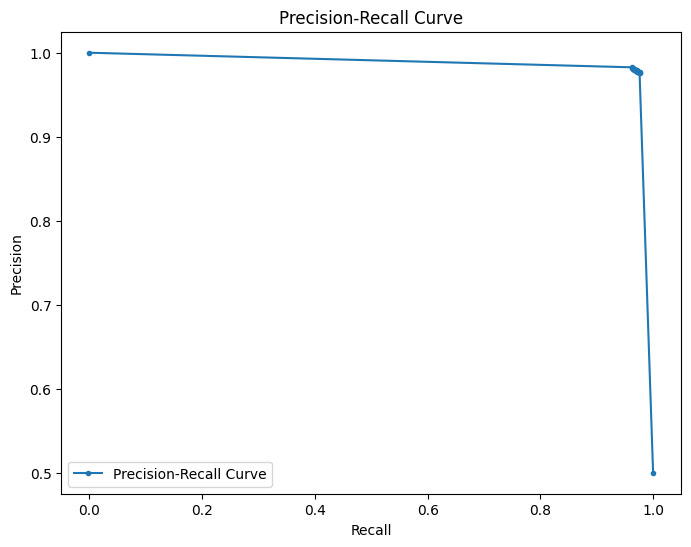

In [51]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

# Assume `pred_probabilities` are the continuous outcomes of your model (probabilities).

# Calculate precision-recall pairs for different probability thresholds
precisions, recalls, thresholds = precision_recall_curve(test_labels, pred_probabilities)

# Plot the precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recalls, precisions, marker='.', label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()


This precision-recall curve indicates an excellent performance of your model across almost all threshold levels.

# 7. Conclusion

Analiysing all metrics and the Precision-Recall Curve of the Convolutional Neural Network (CNN)  and the Fine-Tune VGG16 we can  
tell that the model with Fine-Tune VGG16 is very confident and precise in predicting a sample as positive and also accurate. Given the bad result of Convolutional Neural Network (CNN), we might consider using Data Augmentation or hyperparameter tuning l, which can also can make our model more robust.